# Modello CustomCNN

Importazione Librerie!

In [2]:
import os
import json
import torch
from torch.utils.tensorboard import SummaryWriter
from utils import rinomina_classi_in_dir, undersample_dataset, count_images_per_class, split_train_val_test
from data_loader import get_data_loaders
from model import CustomCNN, TransferMobileNet
from train import train_model
from evaluate import evaluate_model, plot_training, plot_distribution, visualize_sample_images, plot_leaf_type_pie_chart
from jsonschema import validate
import jsonschema

Caricamento del config.json

In [3]:
#Caricamento del Config
with open('config.json', 'r') as f:
    config = json.load(f)

In [4]:
# Caricamento del JSON Schema
with open('config.schema.json', 'r') as f:
    schema = json.load(f)

# Validazione della configurazione
try:
    validate(instance=config, schema=schema)
    print("Configurazione valida.")
except jsonschema.exceptions.ValidationError as err:
    print("Errore nella configurazione:", err)
    raise


Configurazione valida.


Configurazione modello e organizzazione cartelle

In [5]:
# Configurazione
original_dir = config.get("original_data_path", "./Dataset/PlantVillage")
balanced_dir = config.get("balanced_data_path", "./Dataset/PlantVillage_balanced")
split_dir = config.get("split_data_path", "./Dataset/PlantVillage_split")

train_dir = config["train_data_path"]  
val_dir = config["val_data_path"]      
test_dir = config["test_data_path"]    

batch_size = config.get("batch_size", 64)
val_ratio = 0.15     
test_ratio = 0.15      
epochs = config.get("num_epochs", 5)
learning_rate = config.get("learning_rate", 0.001)
target_accuracy = config.get("target_accuracy", 0.95)
early_stopping_patience = config.get("early_stopping_patience", 5)

print(f"Original data dir: {original_dir}")
print(f"Balanced data dir: {balanced_dir}")
print(f"Split data dir: {split_dir}")
print(f"Training dir (loader): {train_dir}")
print(f"Validation dir (loader): {val_dir}")


Original data dir: ./Dataset/PlantVillage
Balanced data dir: ./Dataset/PlantVillage_balanced
Split data dir: ./Dataset/PlantVillage_split
Training dir (loader): ./Dataset/PlantVillage_split/train
Validation dir (loader): ./Dataset/PlantVillage_split/val


Esposizione Immagini del DataSet

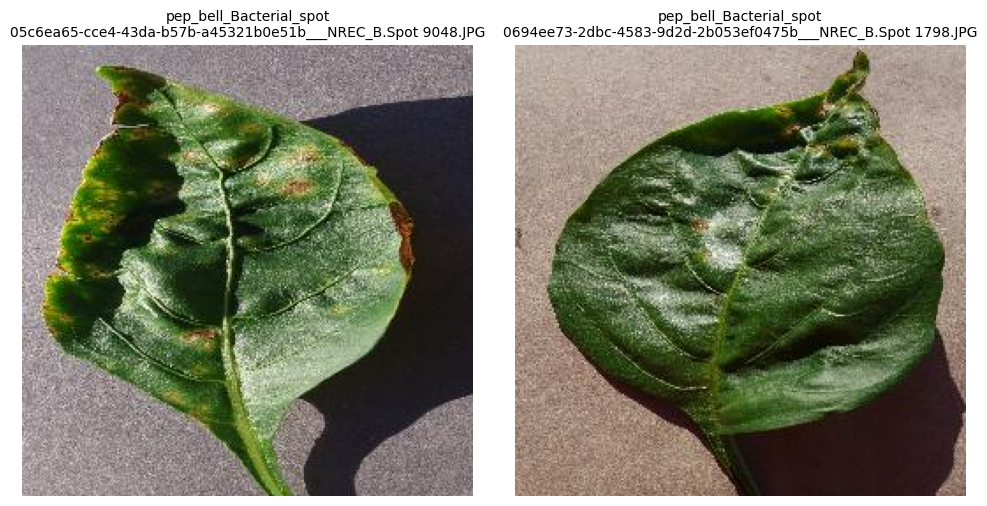

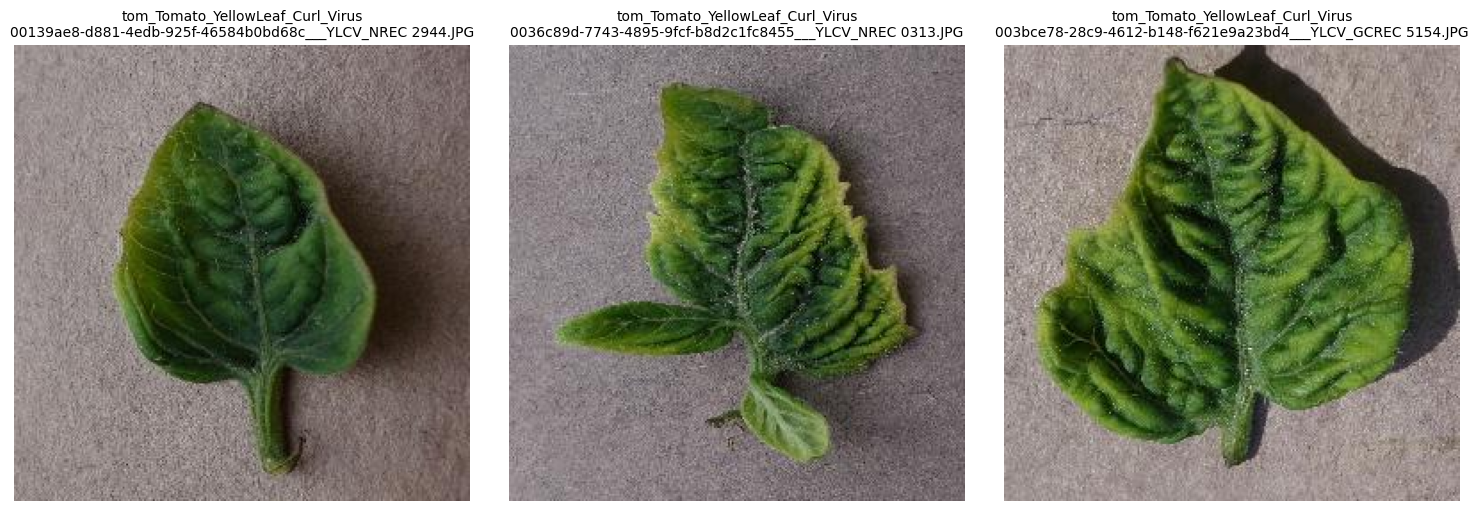

In [6]:
# Mostra 2 immagini qualsiasi da una classe del dataset
visualize_sample_images('./Dataset/PlantVillage')

# Mostra 3 immagini
visualize_sample_images('./Dataset/PlantVillage', class_name='tom_Tomato_YellowLeaf_Curl_Virus', num_images=3)


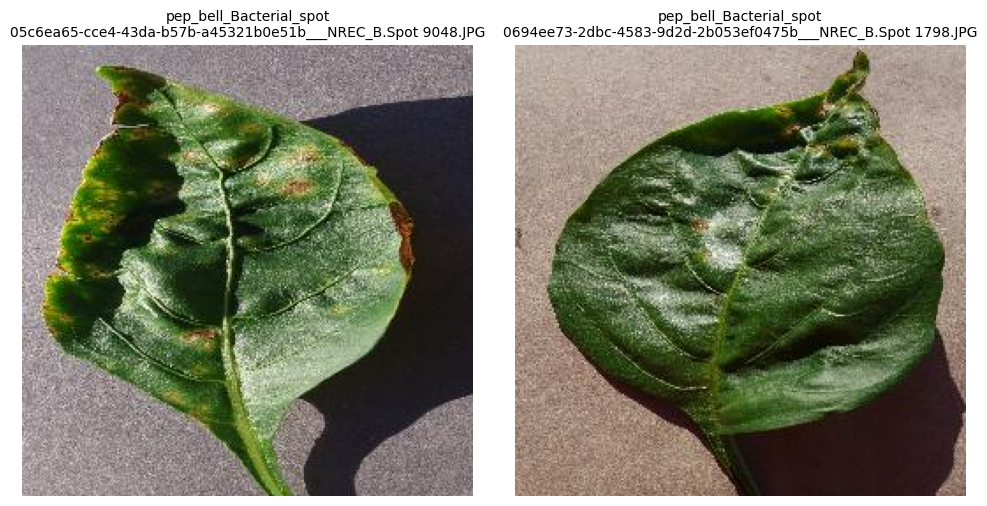

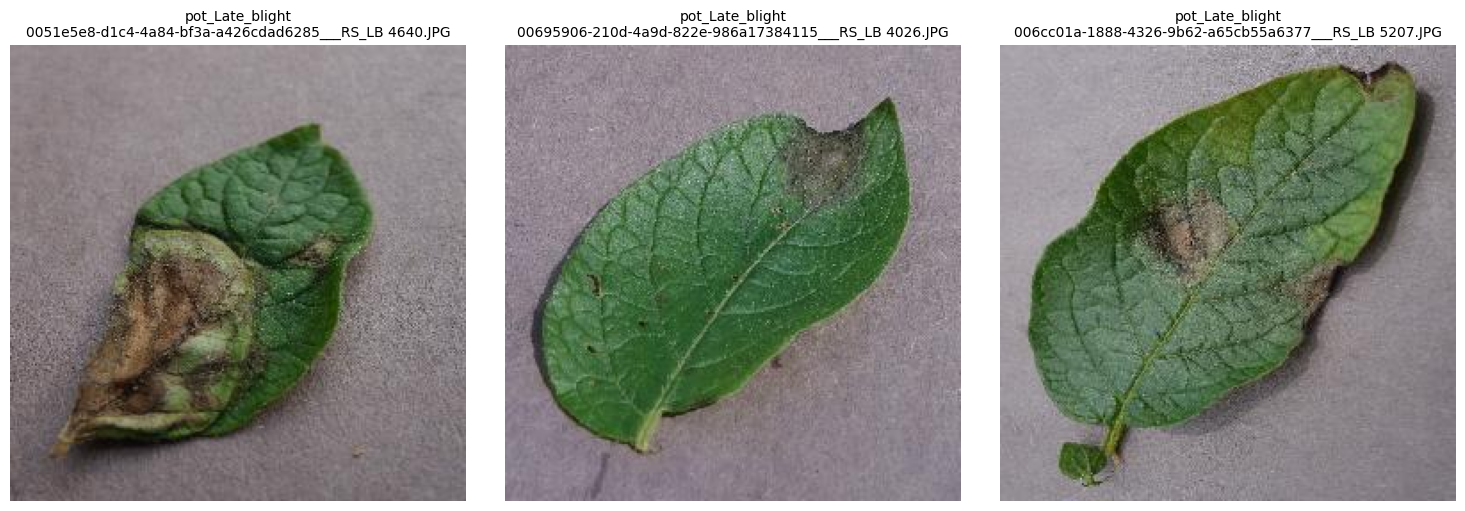

In [7]:
# Mostra 2 immagini qualsiasi da una classe del dataset
visualize_sample_images('./Dataset/PlantVillage')

# Mostra 3 immagini
visualize_sample_images('./Dataset/PlantVillage', class_name='pot_Late_blight', num_images=3)


Riorganizzazione DataSet

In [8]:
# Rinomina classi
rinomina_classi_in_dir(original_dir)

In [9]:
# Undersampling per bilanciare
undersample_dataset(original_dir, balanced_dir, max_per_class=1000)

✅ Dataset ridotto salvato in: ./Dataset/PlantVillage_balanced


Distribuzione originale: {'pep_bell_Bacterial_spot': 976, 'pep_bell_healthy': 1478, 'pot_Early_blight': 1000, 'pot_Late_blight': 1000, 'tom_Bacterial_spot': 2127, 'tom_Early_blight': 1000, 'tom_healthy': 1591, 'tom_Late_blight': 1909, 'tom_Leaf_Mold': 952, 'tom_Septoria_leaf_spot': 1771, 'tom_Spider_mites_Two_spotted_spider_mite': 1676, 'tom_Target_Spot': 1404, 'tom_Tomato_YellowLeaf_Curl_Virus': 3208}
Distribuzione bilanciata: {'pep_bell_Bacterial_spot': 976, 'pep_bell_healthy': 1000, 'pot_Early_blight': 1000, 'pot_Late_blight': 1000, 'tom_Bacterial_spot': 1000, 'tom_Early_blight': 1000, 'tom_healthy': 1000, 'tom_Late_blight': 1000, 'tom_Leaf_Mold': 952, 'tom_Septoria_leaf_spot': 1000, 'tom_Spider_mites_Two_spotted_spider_mite': 1000, 'tom_Target_Spot': 1000, 'tom_Tomato_YellowLeaf_Curl_Virus': 1000}


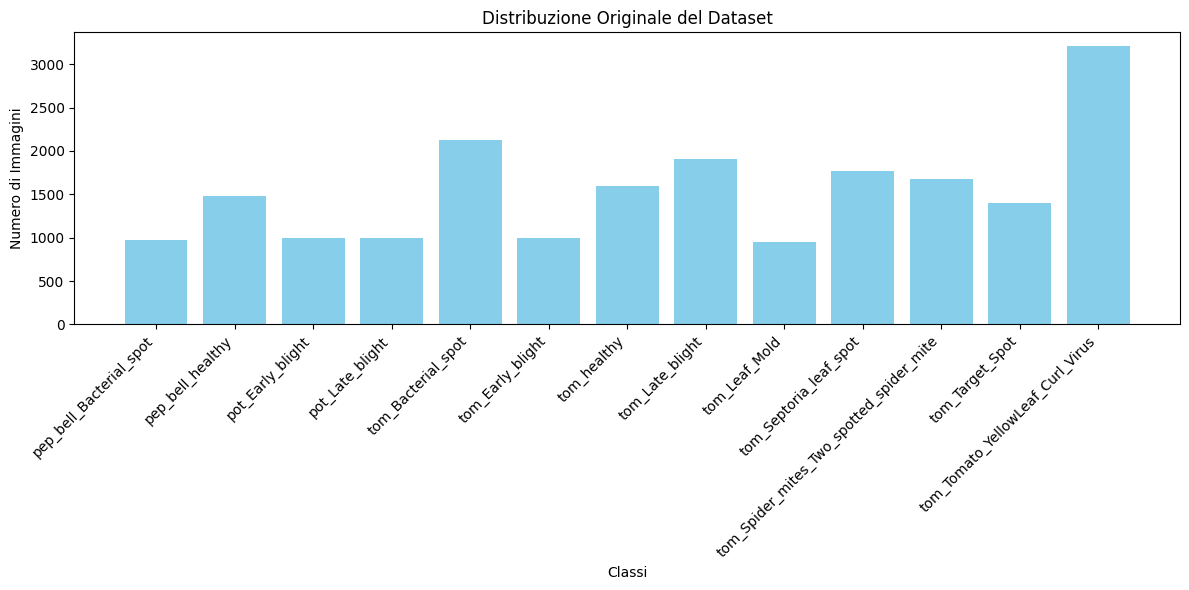

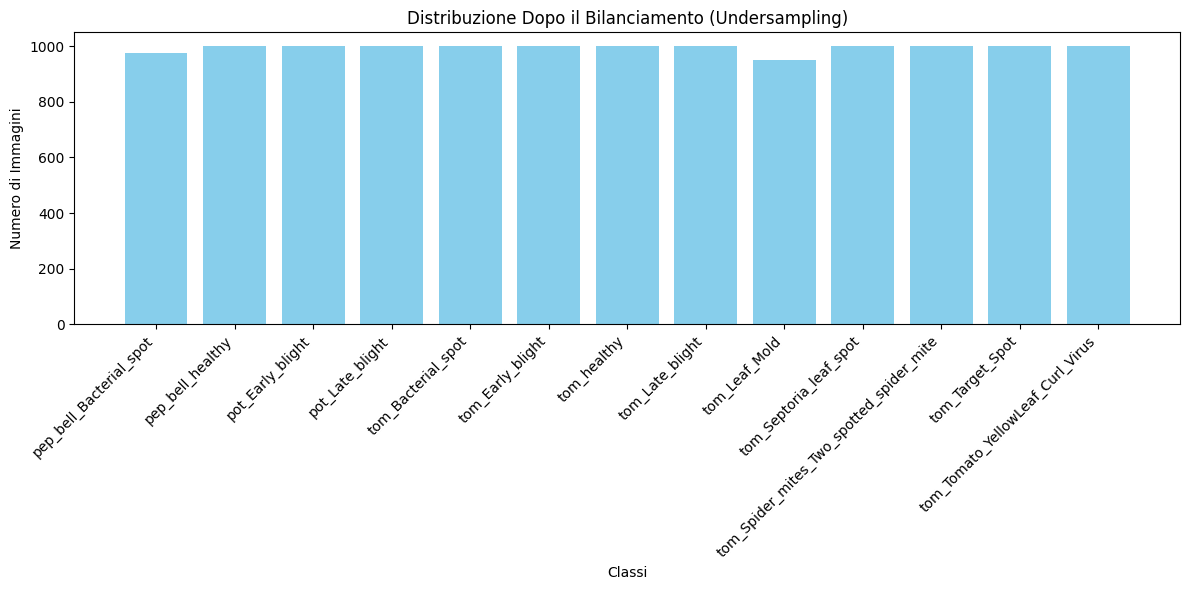

In [ ]:
# Conta immagini e salva le distribuzioni
original_distribution = count_images_per_class(original_dir)
balanced_distribution = count_images_per_class(balanced_dir)
# Stampa conteggi
print("Distribuzione originale:", original_distribution)
print("Distribuzione bilanciata:", balanced_distribution)
# Visualizza distribuzioni
plot_distribution(original_distribution, "Distribuzione Originale del Dataset")
plot_distribution(balanced_distribution, "Distribuzione Dopo il Bilanciamento (Undersampling)")

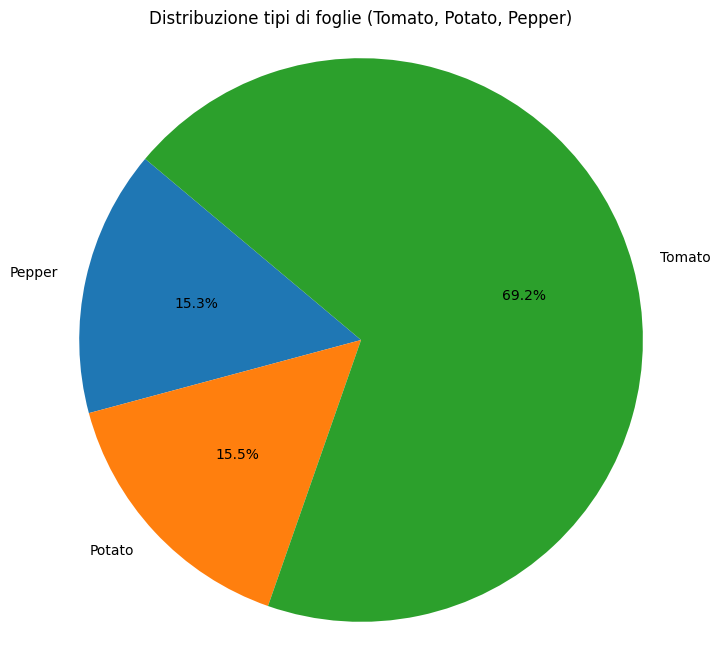

In [ ]:
plot_leaf_type_pie_chart("DataSet/PlantVillage_split/train")

In [ ]:
# Split train/val/test
split_train_val_test(balanced_dir, split_dir, val_ratio=val_ratio, test_ratio=test_ratio)
print("Dataset splittato in train/val/test.")

Dataset splittato in train/val/test.


In [ ]:
# DataLoader
train_loader, val_loader, class_names = get_data_loaders(split_dir, img_size=(224, 224), batch_size=batch_size)
print(f"Classi: {class_names}")

Classi: ['pep_bell_Bacterial_spot', 'pep_bell_healthy', 'pot_Early_blight', 'pot_Late_blight', 'tom_Bacterial_spot', 'tom_Early_blight', 'tom_Late_blight', 'tom_Leaf_Mold', 'tom_Septoria_leaf_spot', 'tom_Spider_mites_Two_spotted_spider_mite', 'tom_Target_Spot', 'tom_Tomato_YellowLeaf_Curl_Virus', 'tom_healthy']


Creazione del Modello

In [ ]:
# Creazione modello e device

model = CustomCNN(num_classes=len(class_names)) #TransferMobileNet(num_classes=len(class_names))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cpu


In [ ]:
# Carico il CheckPoint
checkpoint_path = os.path.join(config.get("checkpoint_dir", "./checkpoints"), "model_best.pth")

Training e andamento training

In [ ]:
# Chiamata Training
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs,
    learning_rate,
    early_stopping_patience=early_stopping_patience,
    target_accuracy=target_accuracy,
    checkpoint_dir=config.get("checkpoint_dir", "./checkpoints"),
    resume_from=None, #'checkpoints\model_best.pth',
    log_dir=config.get("log_dir", "./runs")
)


#tensorboard --logdir=./runs

Epoch 1/5 - Train loss: 2.0359, Train acc: 0.3276 - Val loss: 1.4019, Val acc: 0.5217
Epoch 2/5 - Train loss: 1.4890, Train acc: 0.5031 - Val loss: 1.2858, Val acc: 0.5547
Epoch 3/5 - Train loss: 1.3495, Train acc: 0.5530 - Val loss: 1.1170, Val acc: 0.6383
Epoch 4/5 - Train loss: 1.2604, Train acc: 0.5890 - Val loss: 0.8407, Val acc: 0.7074
Epoch 5/5 - Train loss: 1.2101, Train acc: 0.6033 - Val loss: 1.6648, Val acc: 0.5031


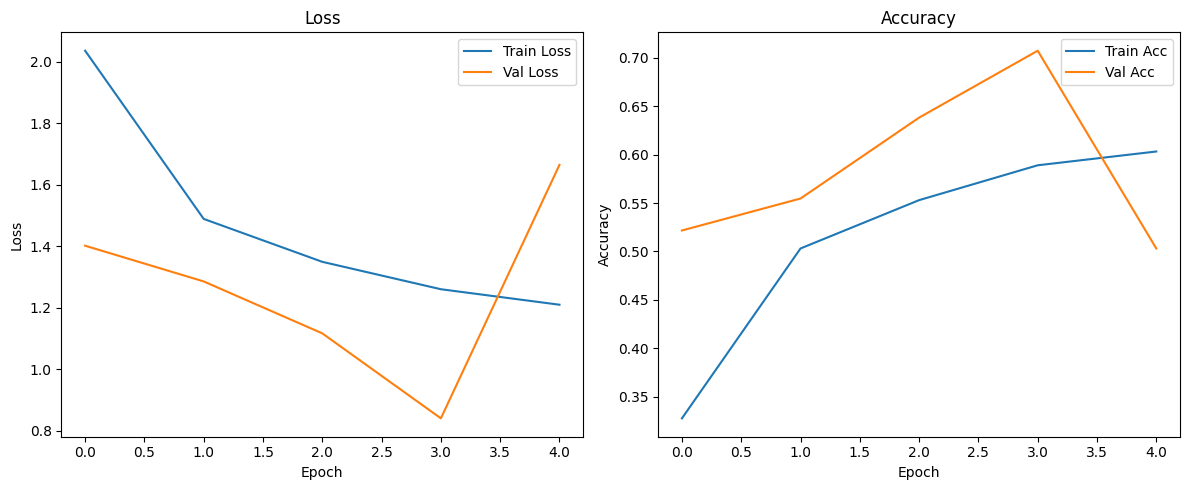

In [ ]:
# Visualizza andamento training
plot_training(train_losses, val_losses, train_accs, val_accs)

Classification Report:
                                          precision    recall  f1-score   support

                 pep_bell_Bacterial_spot       0.69      0.42      0.52       146
                        pep_bell_healthy       1.00      0.02      0.04       150
                        pot_Early_blight       1.00      0.17      0.29       150
                         pot_Late_blight       0.43      0.81      0.56       150
                      tom_Bacterial_spot       0.95      0.58      0.72       150
                        tom_Early_blight       0.93      0.37      0.53       150
                         tom_Late_blight       0.82      0.40      0.54       150
                           tom_Leaf_Mold       0.72      0.31      0.43       142
                  tom_Septoria_leaf_spot       0.29      0.80      0.42       150
tom_Spider_mites_Two_spotted_spider_mite       0.45      0.57      0.50       150
                         tom_Target_Spot       0.32      0.99      0.48   

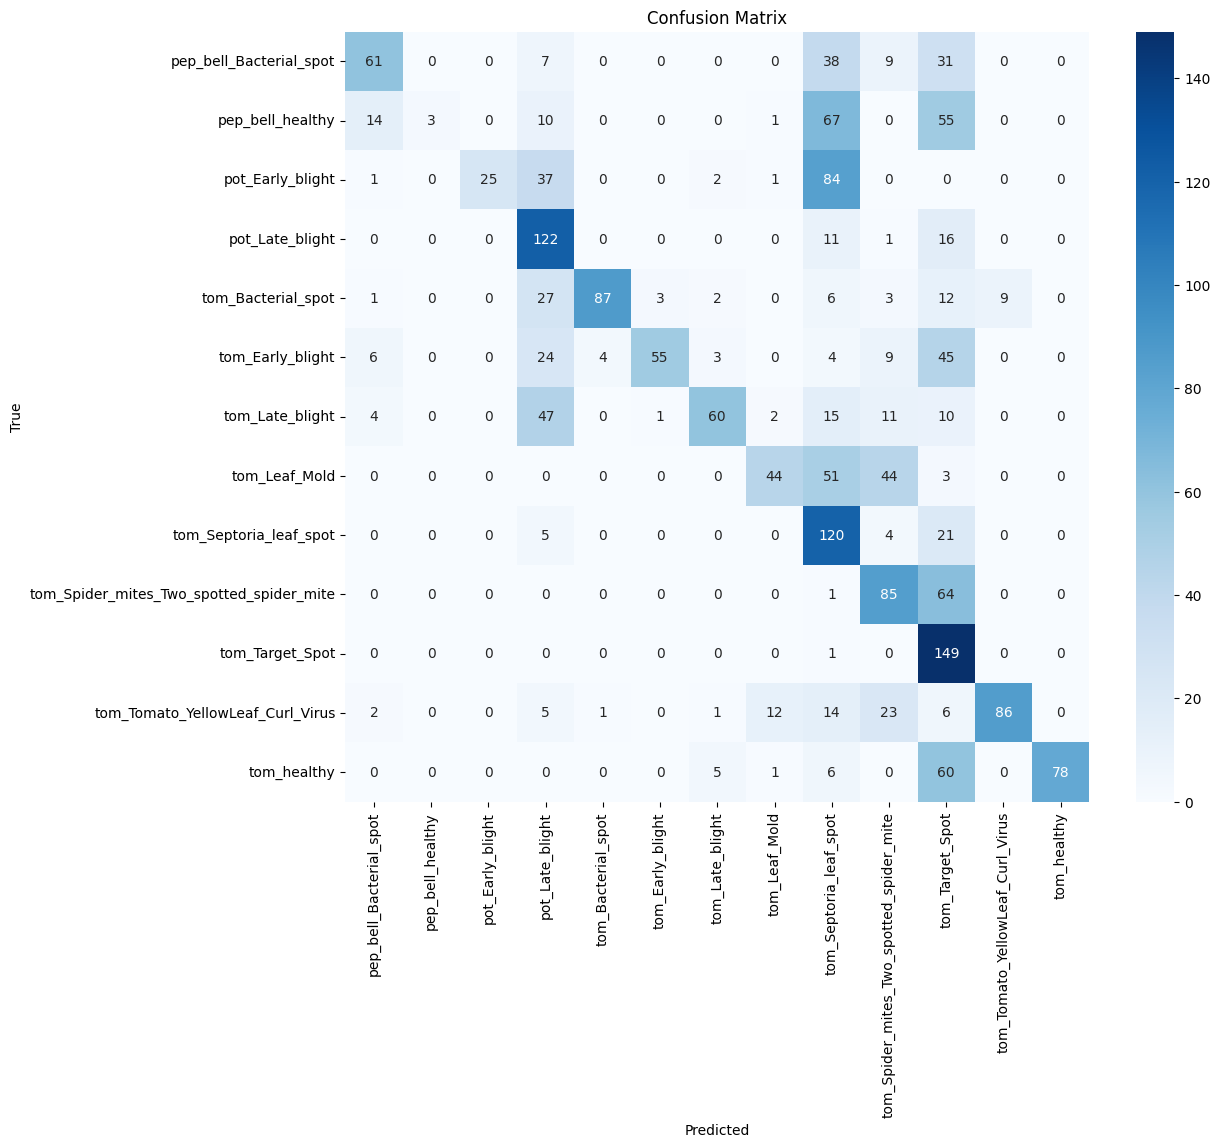

In [ ]:
# Valuta il modello su validation set
evaluate_model(model, val_loader, device, class_names)

Salvataggio del modello

In [ ]:
# Salvataggio Modello finale
torch.save(model.state_dict(), "plantvillage_transfer_model.pth")
print("✅ Modello salvato in plantvillage_transfer_model.pth")

✅ Modello salvato in plantvillage_transfer_model.pth
